In [2]:
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
from dataclasses import dataclass

import jax
import jax.numpy as jnp

import micromage as mg
print(f"{mg.dtype=}")

mg.dtype=<class 'jax.numpy.float32'>


# Ansatz

Initial parameters [16.          2.5         0.7         1.57079633  0.3       ]
Energy 46.551475524902344


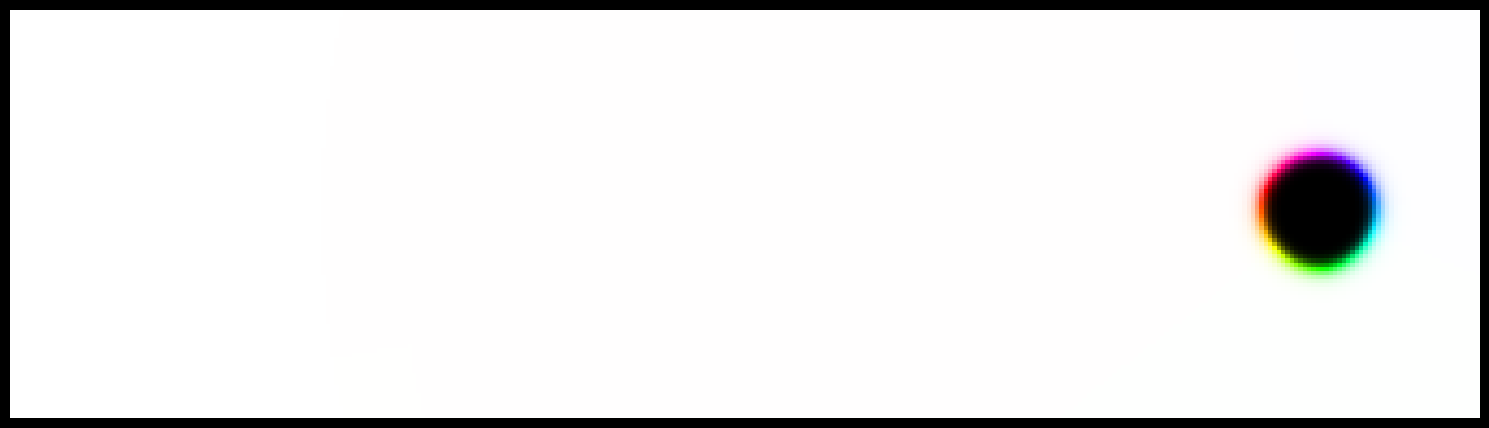

In [12]:
# Parameters can be defined as follows:
system = mg.System(
    Lx=18, Ly=5, D=3.5, K=10,
    jx=1, eta=0.1, beta=0.2,
)

# The following object is requied to do any computations involving the parameters.
comp = mg.Computer2(system)

# Coordinates of points.
xy = comp.coordinates(340, 100)

def ansatz(x0, y0, radius, chirality, width, xy):
    # DOI: 10.1038/s42005-018-0029-0
    x, y = xy[0]-x0, xy[1]-y0 # Cartesian coordinate in place centered at the skyrmion.
    rho2 = x**2+y**2 + 1e-12 #
    rho = jnp.sqrt(rho2) # Polar radius.
    x, y = x/rho, y/rho # Direction outside the skyrmmion.
    n_theta = 2*jnp.arctan2(jnp.sinh(radius/width), jnp.sinh(rho/width)) # Ansatz skyrmion profile.
    nz, nxy = jnp.cos(n_theta), jnp.sin(n_theta) # Out of plane and in plane projections of magnetization.
        
    # n_phi = nu*phi+gamma,  
    # where nu is vorticity (nu = 1 for a skyrmion and nu = −1 for an antiskyrmion), 
    # and gamma is a constant classifying type of skyrmions=chirality 
    # (gamma=0 or pi for Néel skyrmions and gamma = +-pi/2 for Bloch skyrmions).
    c, s = jnp.cos(chirality), jnp.sin(chirality)
    nx = nxy*(c*x-s*y) # x-projection
    ny = nxy*(s*x+c*y) # y-projection of magnetization.
    n1 = jnp.stack([nx,ny,nz],axis=0) # 1st layer.
    return n1[:,:,:,None] # Single layer state.

def ansatz_sym(x0, y0, radius, chirality, width, skew, xy):
    x, y = xy[0]-x0, xy[1]-y0 # Cartesian coordinate in place centered at the skyrmion.
    rho2 = x**2+y**2 + 1e-12 #
    rho = jnp.sqrt(rho2) # Polar radius.
    x, y = x/rho, y/rho # Direction outside the skyrmmion.
    r = radius/rho
    k = 2/width
    n_theta = 2*jnp.arctan(jnp.power(r, k)) # Ansatz skyrmion profile.
    nz, nxy = jnp.cos(n_theta), jnp.sin(n_theta) # Out of plane and in plane projections of magnetization.
        
    # n_phi = nu*phi+gamma,  
    # where nu is vorticity (nu = 1 for a skyrmion and nu = −1 for an antiskyrmion), 
    # and gamma is a constant classifying type of skyrmions=chirality 
    # (gamma=0 or pi for Néel skyrmions and gamma = +-pi/2 for Bloch skyrmions).
    angle = chirality + jnp.log(r)*skew
    c, s = jnp.cos(angle), jnp.sin(angle)
    nx = nxy*(c*x-s*y) # x-projection
    ny = nxy*(s*x+c*y) # y-projection of magnetization.
    n1 = jnp.stack([nx,ny,nz],axis=0) # 1st layer.
    return n1[:,:,:,None] # Single layer state.

    
a = mg.Ansatz(ansatz_sym, argnum=5, computer=comp, args=[0., xy])
p0 = jnp.array([16,2.5,0.7,np.pi/2,0.3])
print(f"Initial parameters", p0)
n0 = a(p0)
print(f"Energy {comp.energy(n0)}")
mg.plot_state(n0, system)
plt.show()

# Geometry

In [15]:
@jax.jit
def fit_params(n, xy):
    ns = n[...,0]
    center = mg.center_of_magnetization(ns, xy)
    r, nz = mg.extract_profile(ns, center, xy)
    rad, wdt = mg.compute_radius(r, nz) 
    phi, n_phi, w = mg.extract_angle(ns, center, xy)
    chi, q = mg.compute_chirality(phi, n_phi, w)
    return jnp.array([center[0],center[1],rad,chi,wdt])

def analyze_geometry(n, xy):
    ns = n[...,0]
    center = mg.center_of_magnetization(ns, xy)
    r, nz = mg.extract_profile(ns, center, xy)
    
    rad, wdt = mg.compute_radius(r, nz)

    phi, n_phi, w = mg.extract_angle(ns, center, xy)
    dphi = (n_phi-phi)/(2*jnp.pi)+0.5
    dphi = jnp.ceil(dphi)-dphi
    dphi = (dphi-0.5)*(2*jnp.pi)
    
    
    b = (1+nz)/(1-nz)
    fig, (ax, cx) = plt.subplots(1,2,figsize=(12,5))
    ax.plot(r, nz, ',b')
    ax.axhline(0, c='b')
    ax.axvline(rad, c='k')
    ax.axvline(rad+wdt/2, c='k', alpha=0.5)
    ax.axvline(rad-wdt/2, c='k', alpha=0.5)
    bx = ax.twinx()
    bx.axhline(1, c='r')
    bx.semilogy(r, b, ',r')
    ax.set_xlabel('Distance to center')
    ax.set_ylabel('Magnetization z-projection')

    cx.plot(phi[w>0], dphi[w>0], ',k')
    cx.set_xlabel('Coordinate polar angle')
    cx.set_ylabel('Magnetization polar angle')

    plt.tight_layout()
    plt.show()



Output()

Center-x: estimate 7.999999794944645, exact 8.0, error 0.00%
Center-y: estimate 7.999999794944645, exact 8.0, error 0.00%
Radius: estimate 2.059348516829458, exact 2.0, error 2.97%
Width: estimate 0.43794017670389285, exact 0.4, error 9.49%
Chirality: estimate 1.5707963267948966, exact 1.5707963267948966, error 0.00%


0: E 11.846 dE 2.01e-02 Step 3.40e-01 Beta 0.00e+00 PE -2.59e-02 SubSteps 1 NegSteps 0 FailedConv 0

Failed to converge

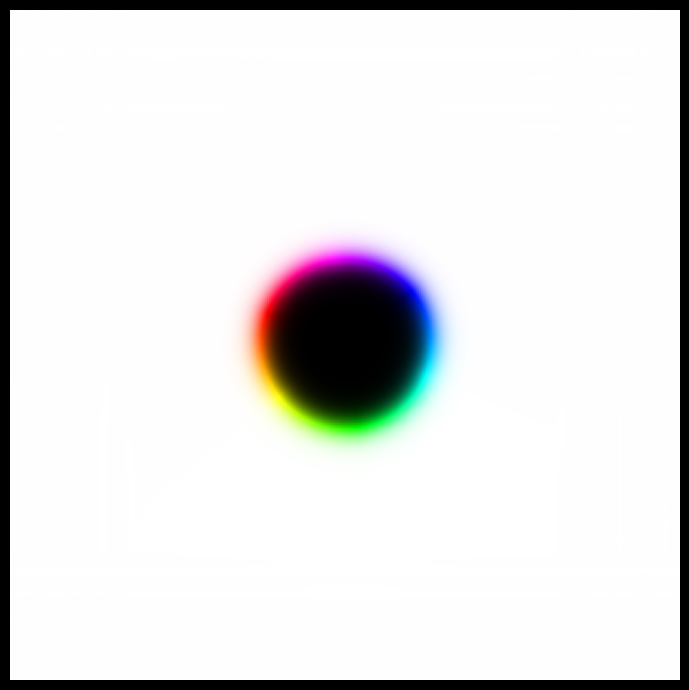

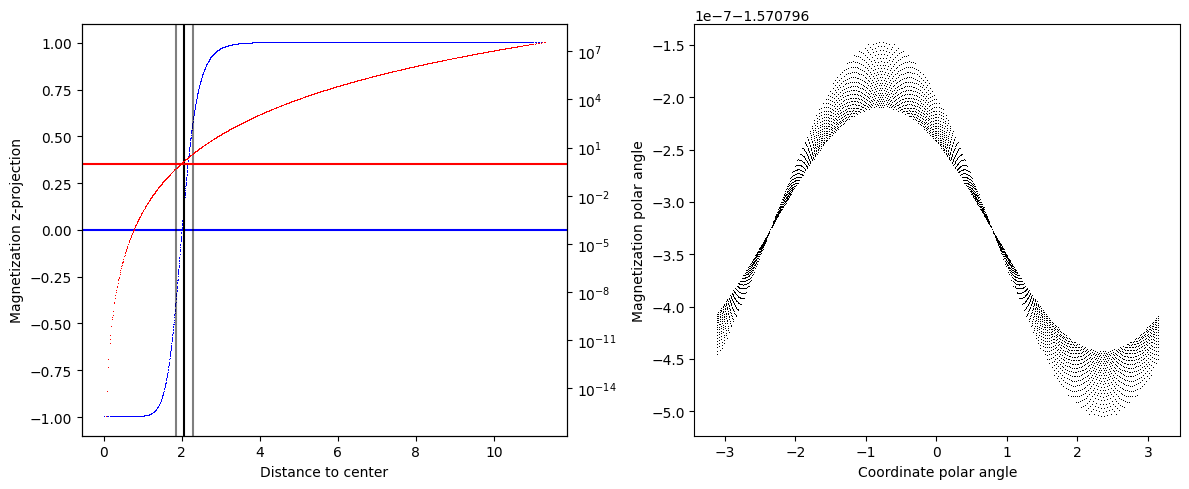

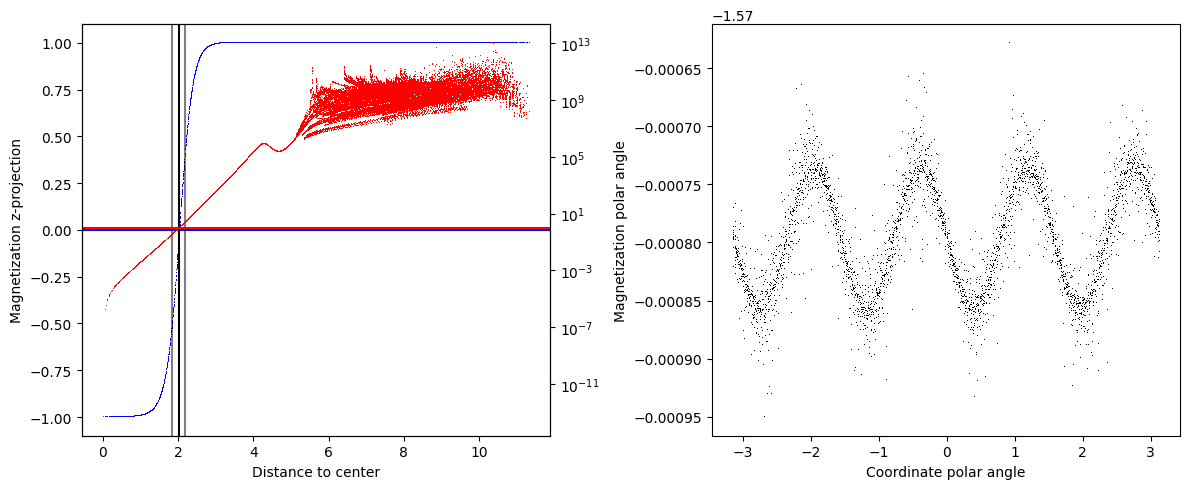

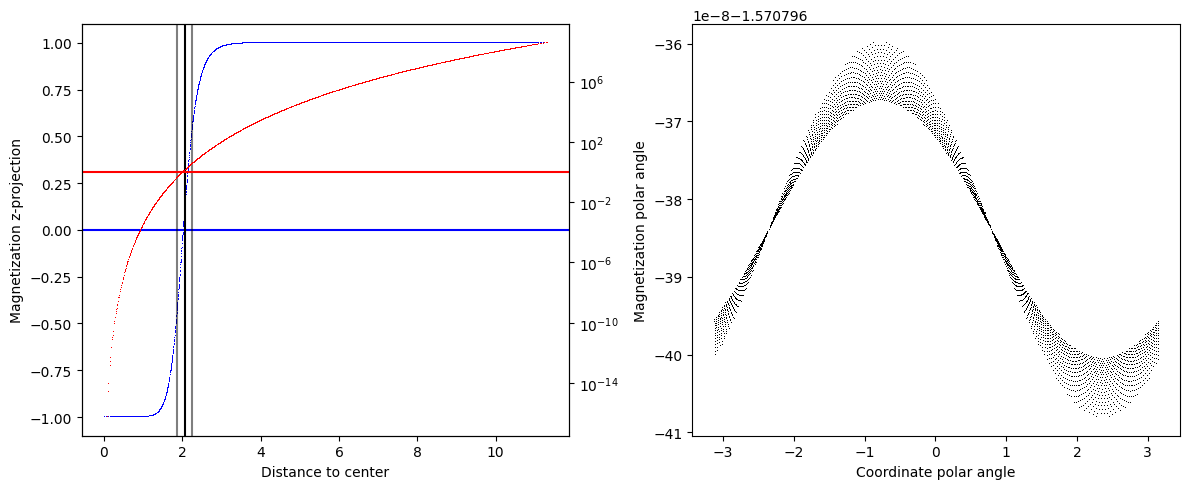

Minimized parameters [8.         8.         2.01839506 1.57079638 0.3494479 ]
Energy minimized   6.233566761016846
Energy from ansatz 8.956789016723633


In [16]:

# Parameters can be defined as follows:
system = mg.System(
    Lx=16, Ly=16, D=3.5, K=8,
    jx=1, eta=0.1, beta=0.2,
)
# The following object is requied to do any computations involving the parameters.
comp = mg.Computer2(system)
# Coordinates of points.
xy = comp.coordinates(300, 300)
a = mg.Ansatz(ansatz_sym, argnum=5, computer=comp, args=[0., xy])


p0 = jnp.array([system.Lx/2,system.Lx/2,2.,np.pi/2,.4])
n0 = a(p0)
p1 = fit_params(n0, xy)
    
def print_est(name,estimate,exact):
    print(f"{name}: estimate {estimate}, exact {exact}, error {np.abs((estimate-exact)/exact)*100:.2f}%")
print_est("Center-x", p1[0], p0[0])
print_est("Center-y", p1[1], p0[1])
print_est("Radius", p1[2], p0[2])
print_est("Width", p1[4], p0[4])
print_est("Chirality", p1[3], p0[3])


n2 = mg.ncg(n0, comp, maxiter=1000, maxsubit=100, maxfails=2)
mg.plot_state(n2, system)

analyze_geometry(n0, xy)

analyze_geometry(n2, xy)
p2 = fit_params(n2, xy)
n3 = a(p2)
analyze_geometry(n3, xy)

print(f"Minimized parameters {p2}")
print(f"Energy minimized   {comp.energy(n2)}")
print(f"Energy from ansatz {comp.energy(n3)}")


# Check projection

In [17]:
system = mg.System(
    Lx=16, Ly=16, D=3.5, K=10,
    eta=0.1, jx=0, beta=0.,
)
print(system)

comp = mg.Computer2(system)
xy = comp.coordinates(300, 300)
a = mg.Ansatz(ansatz, argnum=5, computer=comp, args=[xy])



System(A=1, J=1, D=3.5, H=0, K=10, Lx=16, Ly=16, Ms=1, gamma=1, eta=0.1, beta=0.0, jx=0, jy=0.0)


In [5]:
# p0 = jnp.array([system.Lx/2,system.Ly/2,10.,0.317,np.pi/2])
p0 = jnp.array([8.,         8.00000001, 1.98320925, 1.57081623, 0.34871547])
n = a(p0)
dn = a.computer.time_derivative(n)
print("Grad. projection to the state\n", jnp.sum(n*dn), a.inner(dn,n))
jac = a.jacobian(p0)
mat = a.gram_matrix(jac)
print("Gram matrix\n", mat.round(2))
proj = a.jac_mul(dn, jac)/jnp.diag(mat)
print("Uncorrected projections\n",proj)
proj = a.projections_to_tangent(dn, jac)
print("Projections to tangent\n",proj)
res = a.residual(dn, jac, proj)
print(f"Time der. {a.inner(dn,dn)}, residual {a.inner(res,res)}, dot {a.inner(res,dn)}")
res_proj = a.projections_to_tangent(res, jac)
print("Residual projections to tangent\n",res_proj)
dn1 = dn - res
proj_proj = a.projections_to_tangent(dn1, jac)
print("Projection projections to tangent\n",proj_proj)


# print("Projections to tangent\n", a.time_derivative(p0))


Grad. projection to the state
 1.0658141036401503e-14 1.0658141036401503e-14
Gram matrix
 [[12963.74    -0.      -0.      -0.      -0.  ]
 [   -0.   12963.74    -0.       0.      -0.  ]
 [   -0.      -0.   25124.1     -0.    3645.38]
 [   -0.       0.      -0.    3055.01     0.  ]
 [   -0.      -0.    3645.38     0.   20617.25]]
Uncorrected projections
 [ 1.43467218e-08  5.53178257e-08 -1.33397552e-02  3.79410338e-01
 -8.63803587e-02]
Projections to tangent
 [ 1.43467215e-08  5.53178255e-08 -8.27641574e-04  3.79410338e-01
 -8.62340217e-02]
Time der. 22568.14027722942, residual 21974.510669971023, dot 21974.510669971023
Residual projections to tangent
 [ 6.02909993e-18  5.48099993e-19  1.08666577e-17  0.00000000e+00
 -2.81136185e-17]
Projection projections to tangent
 [ 1.43467215e-08  5.53178255e-08 -8.27641574e-04  3.79410338e-01
 -8.62340217e-02]


# Thiele equation


In [6]:
def pair_plot(n1, n2, system, fig=None, ax=None, im=None, figsize=(15,7)):
    data = [
        mg.vector_to_rgb(n).transpose((1,0,2,3))
        for n in [n1,n2]
    ]
    if im is None:
        if ax is None:
            fig, ax = plt.subplots(2,1,figsize=figsize,facecolor='black',
                                   squeeze=False, sharex=True, sharey=True)
            ax = ax.flatten()
        im = [
            a.imshow(d[:,:,0], origin='lower', extent=(0,system.Lx,0,system.Ly)) 
            for a,d in zip(ax,data)
        ]
        for a in ax: a.set_axis_off()
        fig.set_tight_layout(True)
    else:
        for d,i in zip(data, im):
            i.set_data(d[:,:,0])
    return fig, ax, im

# pair_plot(n0, n0, system)

In [7]:
from rich.progress import Progress
from matplotlib.animation import FFMpegFileWriter

def run_experiment(
        filename, p, ansatz:mg.Ansatz, fit, 
        simulation_period=0.1, dt=0.0001, report_time=0.001
        ):
    a = ansatz
    comp = a.computer
    # Initial state
    t = 0.
    last_report = t
    
    p_thiele = p
    n_llg = a(p_thiele)
    
    # Init data collection
    p_llg = fit(n_llg)
    nfixpar = len(p_llg)-len(p_thiele)
    print(f"Number of fixed parameters: {nfixpar}")
    assert nfixpar>=0
    tail = list(a.args[:nfixpar])
    hist_llg = [p_llg]
    hist_thiele = [list(p_thiele)+tail]    
    energy_llg = [comp.energy(n_llg)]
    energy_thiele = [energy_llg[0]]
    time = [t]

    # Init graphics
    moviewriter = FFMpegFileWriter(fps=23.98, codec='h264')

    fig, ax, im = pair_plot(n_llg, n_llg, system, figsize=(16,9))

    with moviewriter.saving(fig, f'{filename}.mp4', dpi=100):

        with Progress(transient=True) as progress:
            task = progress.add_task("Working", total=simulation_period)

            try:
                while t<simulation_period:
                    n_llg = comp.time_increment(n_llg, dt=dt)
                    p_thiele = a.time_increment(p_thiele, dt=dt)

                    t += dt
                    if t>last_report+report_time:
                        last_report = t

                        n_thiele = a(p_thiele)
                        p_llg = fit(n_llg)
                        e_llg = comp.energy(n_llg)
                        e_thiele = comp.energy(n_thiele)
                        
                        progress.update(task, completed=t)
                        # progress.console.clear()
#                         progress.console.print(f"{t:.3f} [red]Thiele[/] Energy {e_thiele:.3f}", p)
#                         progress.console.print(f"{t:.3f} [green]LLG   [/] Energy {e_llg:.3f}", p1)
                        
                        time.append( t )
                        hist_thiele.append( list(p_thiele)+tail )
                        hist_llg.append( p_llg )
                        energy_thiele.append( e_thiele )
                        energy_llg.append( e_llg )                        

                        pair_plot(n_llg, n_thiele, system, fig=fig, ax=ax, im=im)
                        moviewriter.grab_frame()
            except KeyboardInterrupt:
                pass
        print(f"Finalizing the movie.")
    print(f"Done")

    hist_thiele = np.array(hist_thiele)
    hist_llg = np.array(hist_llg)
    energy_thiele = np.array(energy_thiele)
    energy_llg = np.array(energy_llg)    
    time = np.array(time)

    np.savez(f'{filename}.npz', 
             system=system.__dict__, time=time,
             hist_llg=hist_llg, hist_thiele=hist_thiele,
             energy_llg=energy_llg, energy_thiele=energy_thiele,
             n_llg = n_llg,
            )
    
    return p_thiele, n_llg
 

In [8]:
def plot_param_trajectory(hist, ax, color='k', label='none'):
    x, y, r, chir, w = hist.T
    dx, dy = x[1:]-x[:-1], y[1:]-y[:-1]
    cx, cy, cr = (x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2, (r[1:]+r[:-1])/2
    dd = np.sqrt(dx**2+dy**2)
    tx, ty = dx/dd, dy/dd
    nx, ny = -ty, tx
    
    ax.plot(x, y, c=color, ls='-', label=label)
    ax.plot(cx+nx*cr, cy+ny*cr, c=color, ls=':', label=None)
    ax.plot(cx-nx*cr, cy-ny*cr, c=color, ls=':', label=None)        

    
def plot_result(filename):
    data = np.load(f'{filename}.npz')
    time, hist_llg, hist_thiele, energy_llg, energy_thiele = (
        data['time'], data['hist_llg'], data['hist_thiele'],
        data['energy_llg'], data['energy_thiele'],
    )

    fig, ax = plt.subplots(2, 2, figsize=(10,10), squeeze=False)
    plot_param_trajectory(hist_llg, ax=ax[0][0], color='r', label='LLG')
    plot_param_trajectory(hist_thiele, ax=ax[0][0], color='k', label='Thiele')
    ax[0][0].legend()

    aa = ax[0][1]
    bb = aa.twinx()
    aa.plot(time, hist_llg[:,2], '-r', label='LLG radius')
    bb.plot(time, hist_llg[:,4], '--r', label='LLG width')
    aa.plot(time, hist_thiele[:,2], '-k', label='Thiele radius')
    bb.plot(time, hist_thiele[:,4], '--k', label='Thiele width')
    aa.legend()
    bb.legend()    

    ax[1][0].plot(time, hist_llg[:,3], '-r', label='LLG')
    ax[1][0].plot(time, hist_thiele[:,3], '-k', label='Thiele')
    ax[1][0].set_xlabel('Time')
    ax[1][0].set_ylabel('Chirality')    
    ax[1][0].legend()
    
    ax[1][1].plot(time, energy_llg, '--r', label='LLG')
    ax[1][1].plot(time, energy_thiele, '--k', label='Thiele')  
    ax[1][1].set_xlabel('Time')
    ax[1][1].set_ylabel('Energy') 
    ax[1][1].legend()

    plt.tight_layout()
    plt.savefig(f"{filename}.summary.pdf")
    plt.show()
    
    print(f"Initial Thiele {hist_thiele[0]}")
    print(f"Initial LLG    {hist_llg[0]}")
    print(f"Final Thiele   {hist_thiele[-1]}")
    print(f"Final LLG      {hist_llg[-1]}")
    

# Relaxation test

Output()

System(A=1, J=1, D=3.5, H=-1, K=10, Lx=18, Ly=18, Ms=1, gamma=1, eta=0.2, beta=0.0, jx=0, jy=0.0)
Saving to ../tmp/rlx_Lx18_D3.5_K10_H-1_eta0.2_sx300.npz
Number of fixed parameters: 0


Finalizing the movie.
Done


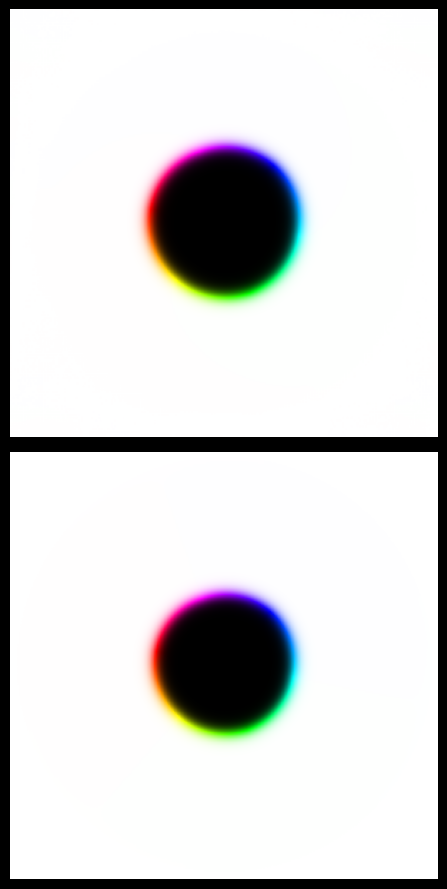

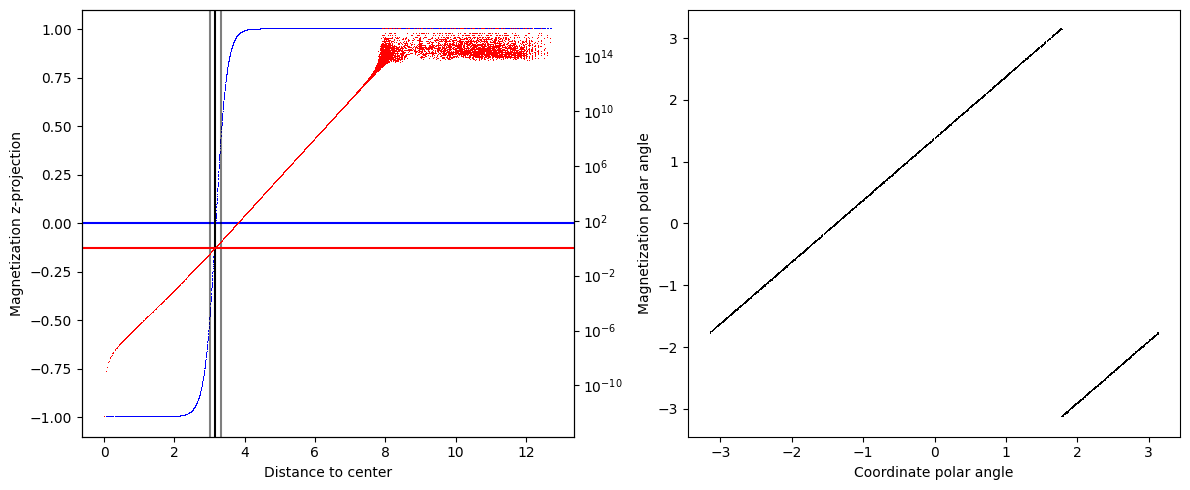

In [9]:
system = mg.System(
    Lx=18, Ly=18, D=3.5, K=10, H=-1,
    eta=0.2, jx=0, beta=0.,
)
print(system)

comp = mg.Computer2(system)
xy = comp.coordinates(300, 300)

# Full ansatz
a = mg.Ansatz(ansatz, argnum=5, computer=comp, args=[xy])
p0 = jnp.array([system.Lx/2,system.Ly/2,0.66,np.pi/2,0.28])
    
# Width + chirality
# a = mg.Ansatz(ansatz, argnum=4, computer=comp, args=[0.28,xy])
# p0 = jnp.array([system.Lx/2,system.Ly/2,0.66,np.pi/2])
      
# Naive ansatz
# a = mg.Ansatz(ansatz, argnum=3, computer=comp, args=[np.pi/2,0.28,xy])
# p0 = jnp.array([system.Lx/2,system.Ly/2,1.0])
  

filename = f'../tmp/rlx_Lx{system.Lx}_D{system.D}_K{system.K}_H{system.H}_eta{system.eta}_sx{xy.shape[1]}'
print(f"Saving to {filename}.npz")
p1, n1 = run_experiment(filename,
    p0, ansatz=a, fit=lambda n: fit_params(n, xy), 
    simulation_period=3., dt=0.0002, report_time=0.01
)
    
analyze_geometry(n1, xy)

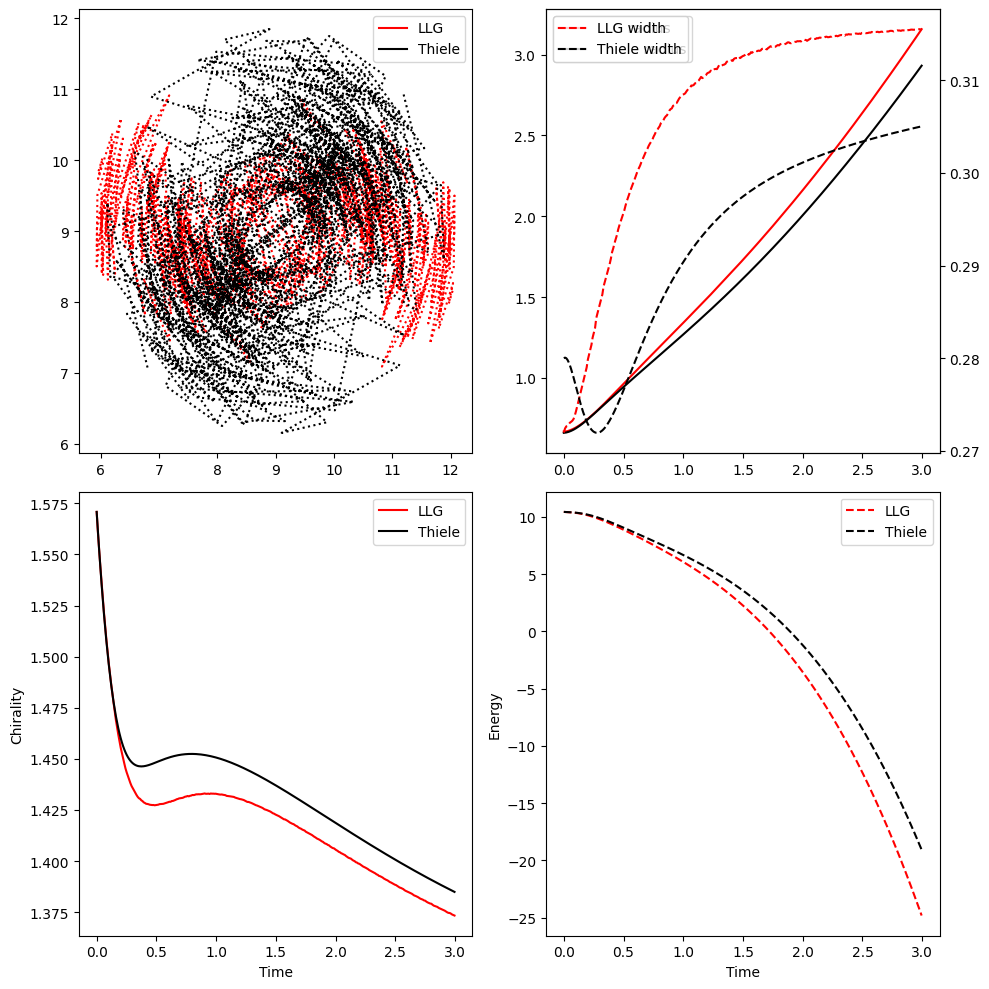

Initial Thiele [9.         9.         0.66       1.57079633 0.28      ]
Initial LLG    [9.         9.         0.66857824 1.57079633 0.27197415]
Final Thiele   [8.99999999 9.00000001 2.93208665 1.38490812 0.30501418]
Final LLG      [8.99999999 9.00000005 3.1579627  1.37334222 0.31544091]


In [10]:
# filename = f'../tmp/sim.L18.eta02.per500.dt001'
plot_result(filename)

# Race track

In [ ]:
# Thiele ansatz parameters.
p0 = jnp.array([16,2.5,0.7,0.3,np.pi/2])
filename = '../tmp/sim'
p1, n1 = run_experiment(filename,
    p0, ansatz=a, fit=lambda n: fit_params(n, xy), 
    simulation_period=2, dt=0.02, report_time=0.2
)
    
analyze_geometry(n1, xy)

Output()

Number of fixed parameters: 0


In [ ]:
plot_result('../tmp/sim')

# Symplectic structure

In [ ]:
# Is breathing and chrirality modes form a pair of generalized coordinate and momentum?
p = jnp.array([8,2.5,3,.7,np.pi/2])
n = a(p)
dp = a.jacobian(p)
# x0, y0, radius, width, chirality = p0
dr = dp[2]
dc = dp[4]
dr2 = -mg.cross(n, dc)

print(np.max(dr[1])/np.max(dr2[1]))

pair_plot(dr/jnp.max(dr)/2, dr2/jnp.max(dr2)/2, system)